### NPPC signature in python:
1. small cell v.s. not small cell (not small cell == IAC + adeno)
2. small cell v.s. adeno
3. iac v.s. adeno

In [87]:
# %load startup_script.py
# system
from pprint import pprint as pp

# numerical & stats 
import pandas as pd
import numpy as np
from scipy import stats

# plotting
from matplotlib import pyplot as plt
import matplotlib
from bokeh.charts import Bar, output_file, show
from bokeh.io import output_notebook


# machine learning
from sklearn import linear_model

# my own module in the same repo
import helper

# jupyte notebook amenities
output_notebook()
%matplotlib inline
%autosave 10


Loading BokehJS ...

Autosaving every 10 seconds


In [2]:
WCDT_mRNA = "./data/WCDT_mRNA.tsv"
WCDT_clinical = "./data/WCDT_clinical.tsv"
WCDT_sample_pairs = "./data/WCDT_paired_samples.tab"
df_mRNA = pd.read_csv(WCDT_mRNA, delimiter="\t")
df_clinical = pd.read_csv(WCDT_clinical, delimiter="\t")
df_sample_pairs = pd.read_csv(WCDT_sample_pairs, delimiter="\t", index_col="Sample")

In [3]:
def extract_label(df_clinical):
    # extract information from classification #1
    y_df = df_clinical[["Patient ID", "Classification #1",]].copy()
    y_df.rename(columns={"Classification #1":"NEPC_label", "Patient ID": "Patient_ID"}, inplace=True)
    y_df = y_df[y_df["NEPC_label"]!="Exclude"].copy()
    
    # uniform various naming discrepancies
    y_df.set_index("Patient_ID", inplace=True)
    y_df[y_df["NEPC_label"].isin(["Small cell", "Small Cell"])] = "scnc"
    y_df[y_df["NEPC_label"].isin(["Adenocarcinoma", "Adeno"])] = "adeno"
    y_df[y_df["NEPC_label"].isin(["IAC"])] = "iac"
    return y_df

In [4]:
def data_prep(x=df_mRNA, y=df_clinical, group1=["scnc"], group0=["adeno"]):
    """ 
    extract the samples in label group zero v.s. label group one, 
    in training, the former is assigned a label of 0 and the latter is asigned a label of 1
    """
    # extract desired groups from y
    y = extract_label(df_clinical)
    y[y["NEPC_label"].isin(group1)] = 1
    y[y["NEPC_label"].isin(group0)] = 0
    y = y[y["NEPC_label"].isin([0, 1])]

    # get sample overlap between mRNA and y
    X = df_mRNA.set_index("gene_id").transpose()
    overlap = set(X.index).intersection(set(y.index))
    y = y[y.index.isin(overlap)]
    X = X[X.index.isin(overlap)]
    
    # order X and Y so that same sample name match up
    X.sort_index(inplace=True)
    y.sort_index(inplace=True)
    assert(list(X.index) == list(y.index))
    
    return X, y    

In [5]:
def calc_signature(X, y, name, classifier=linear_model.LogisticRegression()):
    classifier.fit(X, np.array(list(y['NEPC_label'])))
    return pd.DataFrame(index=X.columns, data=classifier.coef_[0], columns=[name])

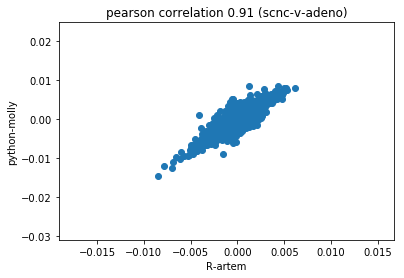

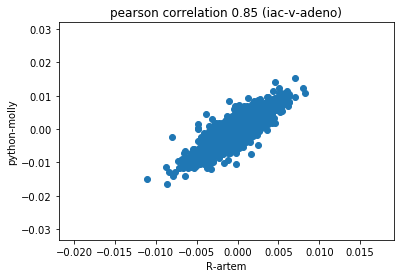

In [6]:
# Comparison with Artem's NEPC signature
for comparison in ["scnc-v-adeno", "iac-v-adeno"]:
    # get python gene signature
    group0 = comparison.split("-")[-1]
    group1 = comparison.split("-")[0]
    X, y = data_prep(group0=[group0], group1=[group1])
    python_sig = calc_signature(X, y, "python")
    
    # get gene overlap between artem signature and python signature
    artem_file = "data/NEPC/{0}-20k-sig.rnk".format(comparison)
    artem_sig = pd.read_csv(artem_file, delimiter="\t", names=["gene","artem"], index_col=0)
    sigs = pd.concat([python_sig, artem_sig], axis=1, join="inner")
    
    # plot
    plt.figure(comparison)
    plt.scatter(sigs["artem"], sigs["python"])
    plt.title("pearson correlation %.2f (%s)" %(stats.pearsonr(sigs["artem"], sigs["python"])[0], comparison))
    plt.xlabel("R-artem")
    plt.ylabel("python-molly")

In [7]:
# leave pair out cross validation aucs
X, y = data_prep(group0=["adeno"], group1=["scnc"])
print(helper.leave_pair_out_cv(X, y, linear_model.LogisticRegression()))

............................................................................................................................................................................................................................................................................................................................................................................................0.8657894736842106


In [8]:
X, y = data_prep(group0=["adeno"], group1=["iac"])
print(helper.leave_pair_out_cv(X, y, linear_model.LogisticRegression()))

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................0.6421052631578947


In [10]:
X, y = data_prep(group0=["adeno", "iac"], group1=["scnc"])
print(helper.leave_pair_out_cv(X, y, linear_model.LogisticRegression()))

......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................0.8444444444444444


In [9]:
X, y = data_prep(group0=["adeno", "scnc"], group1=["iac"])
print(helper.leave_pair_out_cv(X, y, linear_model.LogisticRegression()))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [11]:
X, y = data_prep(group0=["adeno"], group1=["iac", "scnc"])
print(helper.leave_pair_out_cv(X, y, linear_model.LogisticRegression()))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [12]:
X, y = data_prep(group0=["iac"], group1=["scnc"])
print(helper.leave_pair_out_cv(X, y, linear_model.LogisticRegression()))

..........................................................................................................................................................................................................................................................0.776


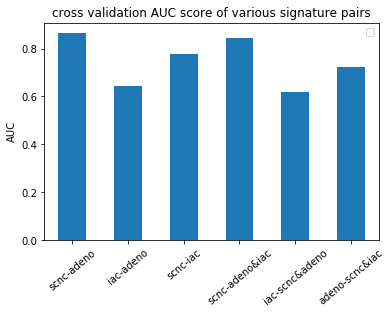

In [8]:
# plot and compare various cross validaiton auc
sample_pairs = ["scnc-adeno", "iac-adeno", "scnc-iac", 
                "scnc-adeno&iac", "iac-scnc&adeno", "adeno-scnc&iac"]
AUCs = [0.8658, 0.6421, 0.776, 0.8444, 0.6175, 0.7233]
df = pd.DataFrame(index=sample_pairs, data=AUCs, columns=["AUC"])
figure, ax = plt.subplots()
df.plot.bar(rot=40, ax=ax)
plt.title("cross validation AUC score of various signature pairs")
plt.ylabel("AUC")
plt.legend([])

In [10]:
# get all sorts of signatures
sample_pairs = ["scnc-adeno", "iac-adeno", "scnc-iac", 
                "scnc-adeno&iac", "iac-scnc&adeno", "adeno-scnc&iac"]
lr = linear_model.LogisticRegression()
all_sigs = pd.DataFrame(index=X.columns)
for sample_pair in sample_pairs:
    group1 = [sample_pair.split("-")[0]]
    group0 = sample_pair.split("-")[-1].split("&")
    X, y = data_prep(group0=group0, group1=group1)
    this_sig = calc_signature(X, y, sample_pair)
    all_sigs[sample_pair] = calc_signature(X, y, sample_pair)[sample_pair]
all_sigs.to_pickle("./data/NEPC/NEPC_sigs.pkl")

In [11]:
# apply NEPC signatures to known samples
all_sigs = pd.read_pickle("./data/NEPC/NEPC_sigs.pkl")

In [12]:
# combine NEPC label with WCDT pre/post enza time point
def get_label(sample):
    try:
        return df_y.loc[sample].NEPC_label
    except KeyError:
        return np.nan
    except:
        raise

df_y = extract_label(df_clinical)
df_sample_pairs["NEPC_label"] = list(map(get_label, df_sample_pairs.index))
print(df_sample_pairs)        

            TimePoint NEPC_label
Sample                          
DTB-022Pro        Pre      adeno
DTB-024Pro        Pre        NaN
DTB-060           Pre        NaN
DTB-063           Pre      adeno
DTB-073           Pre      adeno
DTB-080           Pre        iac
DTB-089           Pre      adeno
DTB-102           Pre        iac
DTB-111           Pre        NaN
DTB-127           Pre        iac
DTB-135           Pre        NaN
DTB-137           Pre      adeno
DTB-141           Pre      adeno
DTB-149           Pre      adeno
DTB-176           Pre       scnc
DTB-194           Pre        NaN
DTB-022Pro2      Post        NaN
DTB-024Pro2      Post        NaN
DTB-060Pro       Post        NaN
DTB-063Pro       Post      adeno
DTB-073Pro       Post        NaN
DTB-080Pro       Post        NaN
DTB-089Pro       Post      adeno
DTB-102Pro       Post        NaN
DTB-111Pro       Post        iac
DTB-127Pro       Post        iac
DTB-135Pro       Post       scnc
DTB-137Pro       Post        NaN
DTB-141Pro

### apply NEPC signature (all six pairs) to WCDT pre-post sample and plot them

In [13]:
df_WCDT_enza = df_mRNA.set_index("gene_id").T.loc[list(df_sample_pairs.index)]

assert(list(df_WCDT_enza.columns) == list(all_sigs.index))
assert(list(df_WCDT_enza.index) == list(df_sample_pairs.index))
all_sig_scores = pd.DataFrame(data=np.matmul(df_WCDT_enza.as_matrix(), all_sigs.as_matrix()), 
                              index=df_WCDT_enza.index, 
                              columns=all_sigs.columns)

df_combined = pd.concat([all_sig_scores, df_sample_pairs], axis=1)
df_combined

,scnc-adeno,iac-adeno,scnc-iac,scnc-adeno&iac,iac-scnc&adeno,adeno-scnc&iac,TimePoint,NEPC_label
Sample,,,,,,,,
DTB-022Pro,-9.965143,-9.536551,-5.297048,-10.507991,-9.684101,9.301889,Pre,adeno
DTB-024Pro,-7.247127,-4.264942,-5.758625,-8.907042,-5.250079,1.907963,Pre,NaN
DTB-060,-9.005758,-0.999607,-9.853151,-12.075284,-1.363638,1.798729,Pre,NaN
DTB-063,-10.246354,-8.954408,-6.802047,-11.594700,-8.924375,8.884372,Pre,adeno
DTB-073,-9.066752,-9.027112,-3.957443,-9.333057,-9.288785,8.634950,Pre,adeno
DTB-080,-6.505541,8.436177,-9.905538,-10.814622,8.325507,-8.474478,Pre,iac
DTB-089,-10.401235,-9.108295,-8.466657,-11.784340,-9.118823,8.950613,Pre,adeno
DTB-102,-11.119274,8.902440,-10.616930,-12.375421,8.788275,-8.850866,Pre,iac
DTB-111,-0.120757,4.149063,-2.790817,-3.482054,2.450785,-7.868412,Pre,NaN


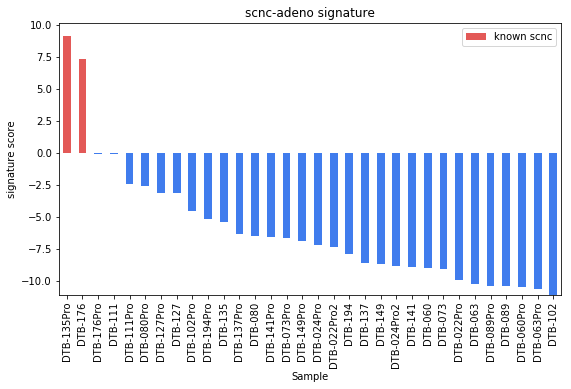

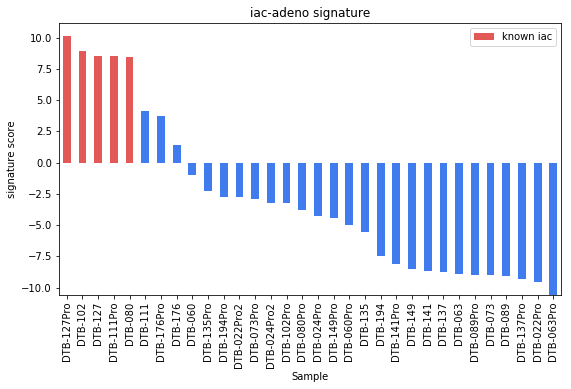

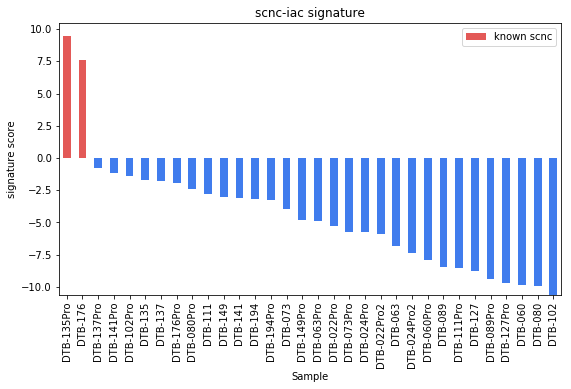

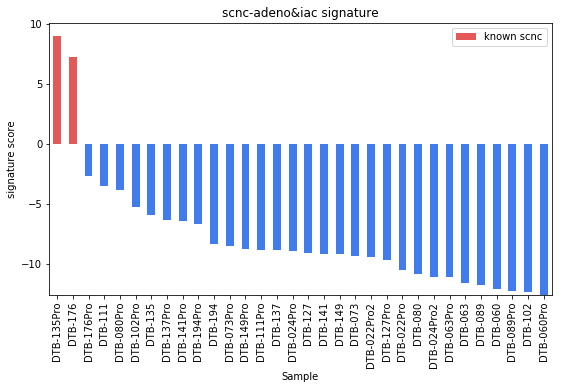

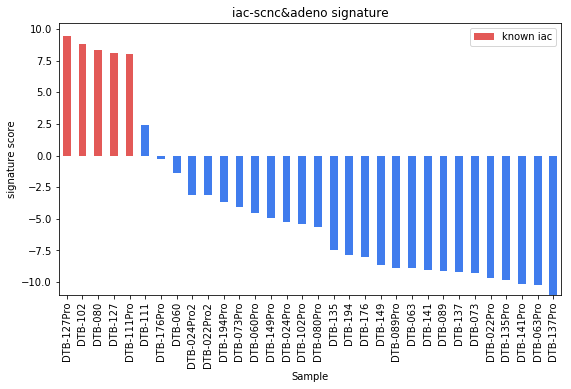

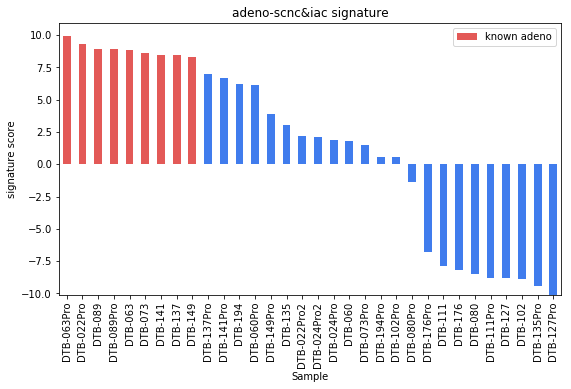

In [61]:
for sig in all_sigs.columns:
    plt.figure(sig, figsize=(9,5))
    group1 = sig.split("-")[0]
    this_sig = df_combined.sort_values(by=sig, ascending=False)
    highlight = list(this_sig[this_sig["NEPC_label"] == group1].index)
    rest = list(this_sig[this_sig["NEPC_label"] != group1].index)
    colors = dict(zip(highlight + rest, ["#E35957"] * len(highlight) + ["#407CED"] * len(rest)))
    this_sig[sig].plot.bar(color=[colors[i] for i in this_sig.index])
    plt.title(sig + " signature")
    plt.ylabel("signature score")
    plt.legend(["known " + group1])

In [17]:
# now convert the same graph into post-pre difference plot
df_combined_pre = df_combined[df_combined.TimePoint == "Pre"].copy()
df_combined_post = df_combined[df_combined.TimePoint == "Post"].copy()
df_combined_pre.rename(index={"DTB-022Pro": "DTB-022", "DTB-024Pro": "DTB-024"}, inplace=True)
rename_dict = dict(zip(df_combined_post.index, [i[:7] for i in df_combined_post.index]))
df_combined_post.rename(index=rename_dict, inplace=True)
df_combined_pre.drop(["TimePoint", "NEPC_label"], axis=1, inplace=True)
df_combined_post.drop(["TimePoint", "NEPC_label"], axis=1, inplace=True)
assert(list(df_combined_pre) == list(df_combined_post))
df_combined_post_pre = df_combined_post - df_combined_pre
df_combined_post_pre

,scnc-adeno,iac-adeno,scnc-iac,scnc-adeno&iac,iac-scnc&adeno,adeno-scnc&iac
Sample,,,,,,
DTB-022,2.564996,6.751096,-0.633487,1.068229,6.569181,-7.140033
DTB-024,-1.602473,1.070264,-1.628747,-2.161362,2.140578,0.174540
DTB-060,-1.509192,-3.965503,1.959263,-0.507338,-3.159222,4.314473
DTB-063,-0.422323,-1.638824,1.906749,0.523943,-1.334955,1.045269
DTB-073,2.368584,6.140346,-1.750615,0.823379,5.221038,-7.126864
DTB-080,3.935232,-12.263056,7.465601,6.940368,-13.994894,7.119112
DTB-089,0.014642,0.129393,-0.928586,-0.485689,0.225844,-0.053614
DTB-102,6.577042,-12.154680,9.223174,7.148967,-14.173116,9.386116
DTB-111,-2.304086,4.362969,-5.764218,-5.333429,5.590838,-0.897440


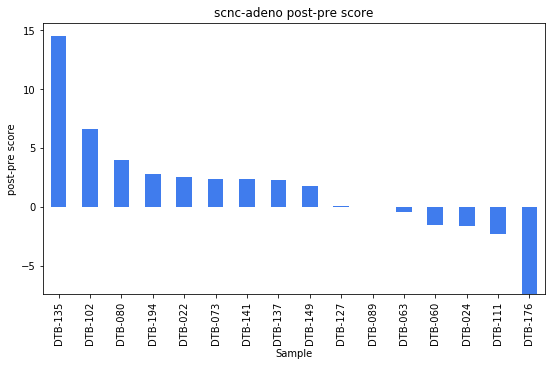

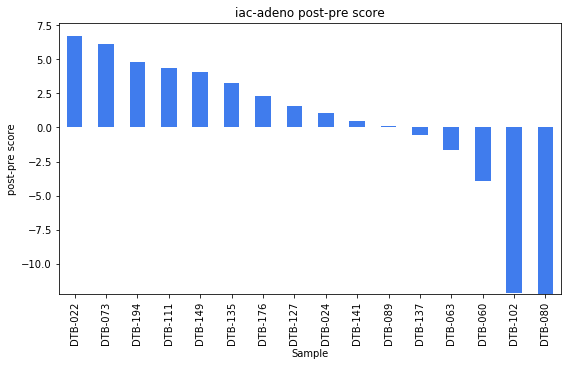

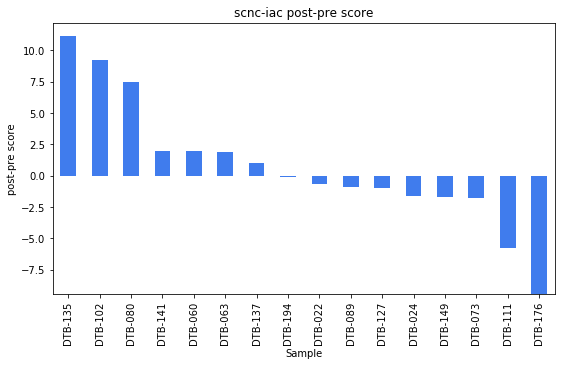

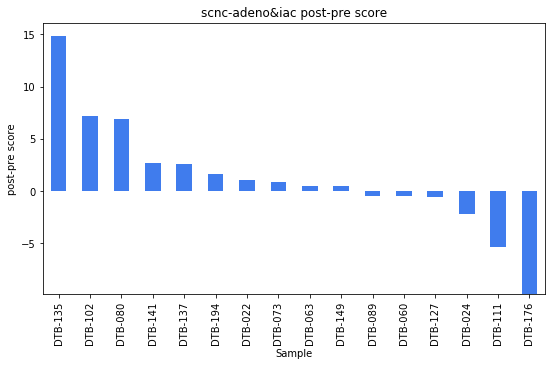

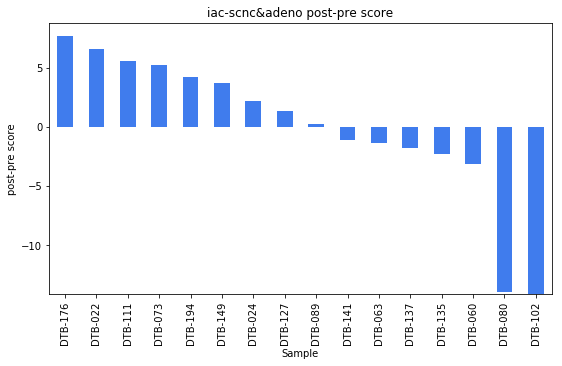

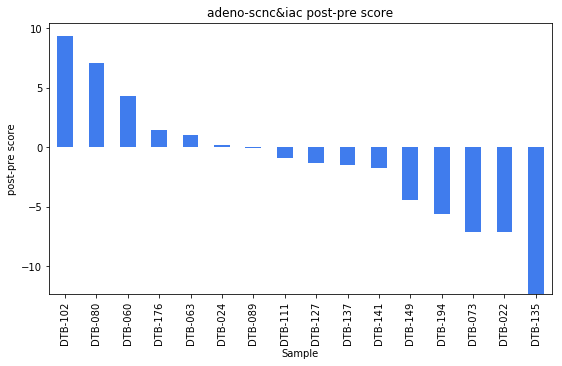

In [18]:
for sig in df_combined_post_pre.columns:
    plt.figure(sig, figsize=(9,5))
    group1 = sig.split("-")[0]
    this_df = df_combined_post_pre.sort_values(by=sig, ascending=False)
    this_df[sig].plot.bar(color=["#407CED"])
    plt.title(sig + " post-pre score")
    plt.ylabel("post-pre score")

### Make change to one plot based on Joshi's request (June-9-2017)

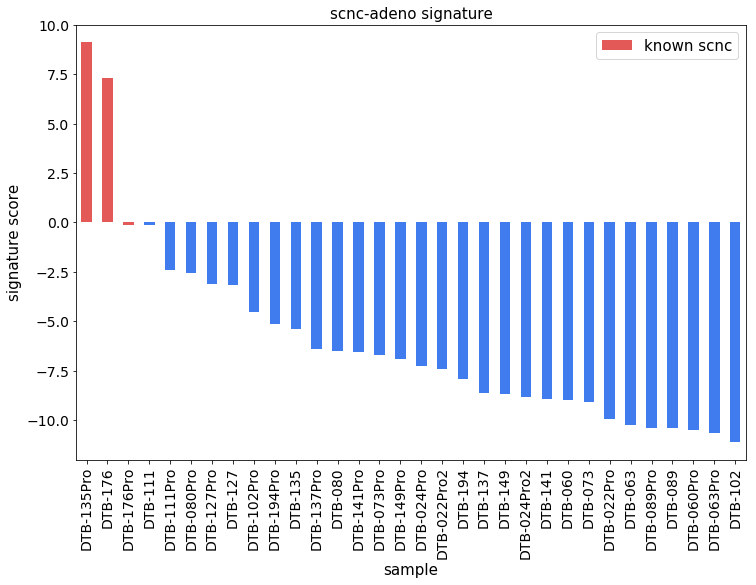

In [100]:
### add "DTB-176Pro" to scnc label

plt.figure(figsize=(9,5))
this_sig = df_combined[["scnc-adeno", "TimePoint", "NEPC_label"]].copy().sort_values(by="scnc-adeno", ascending=False)
this_sig.set_value("DTB-176Pro", "NEPC_label", "scnc") ####### Here is the real change

highlight = list(this_sig[this_sig["NEPC_label"] == "scnc"].index)
rest = list(this_sig[this_sig["NEPC_label"] != "scnc"].index)
colors = dict(zip(highlight + rest, ["#E35957"] * len(highlight) + ["#407CED"] * len(rest)))

this_sig["scnc-adeno"].plot.bar(color=[colors[i] for i in this_sig.index], figsize=(12,8), fontsize=14)

plt.title("scnc-adeno" + " signature", fontsize=15)
plt.ylabel("signature score", fontsize=15)
plt.ylim((-12,10))
plt.xlabel("sample", fontsize=15)
plt.legend(["known " + "scnc"], fontsize=15)

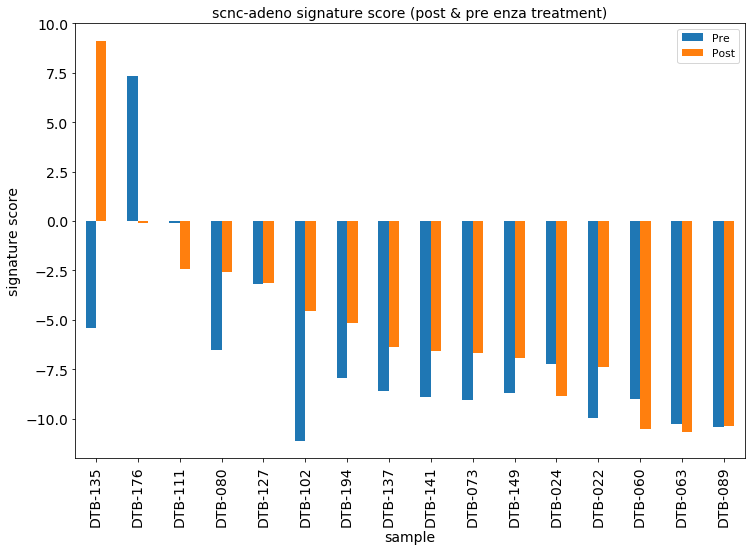

In [99]:
### plot same graph with sample post-pre values side by side
def extract_sample_name(name):
    if name.endswith("Pro"):
        return name[:-3]
    elif name.endswith("Pro2"):
        return name[:-4]
    else:
        assert(name[-1] in "0123456789")
        return name

sample_pair = pd.read_csv("./data/WCDT_paired_samples.tab", delimiter="\t", index_col="Sample")
assert(sorted(list(sample_pair.index))==sorted(list(this_sig.index)))
sample_pair_dict = dict(zip(sample_pair.index, sample_pair['TimePoint']))
this_sig_pair = pd.DataFrame(columns=["Pre", "Post"])
for index, row in this_sig.iterrows():
    sample_name = extract_sample_name(index)
    sample_type = sample_pair_dict[index]
    this_sig_pair.set_value(sample_name, sample_type, row["scnc-adeno"])

this_sig_pair.plot.bar(figsize=(12,8), fontsize=14)
plt.title("scnc-adeno signature score (post & pre enza treatment)", fontsize=14)
plt.ylabel("signature score", fontsize=14)
plt.ylim((-12,10))
plt.xlabel("sample", fontsize=14)